In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
# Step 1: Data Ingestion
def load_data(filepath):
    data = pd.read_csv(filepath, sep=';')
    return data

In [3]:
data = load_data("bank.csv")

In [4]:
data.shape

(41188, 21)

In [5]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Dataset Shape: (41188, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  fl

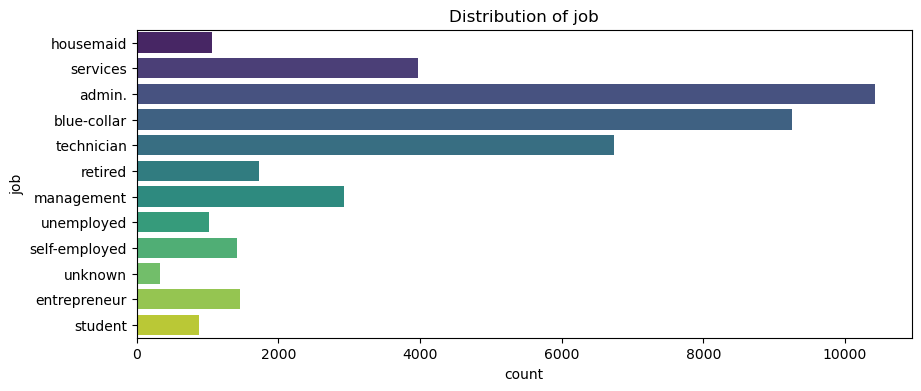

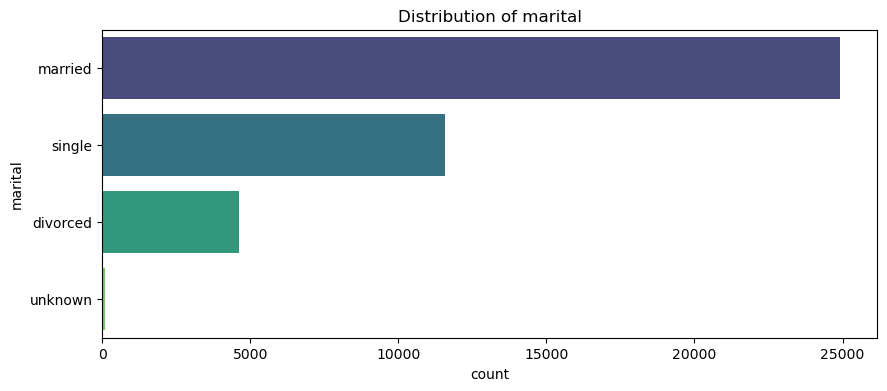

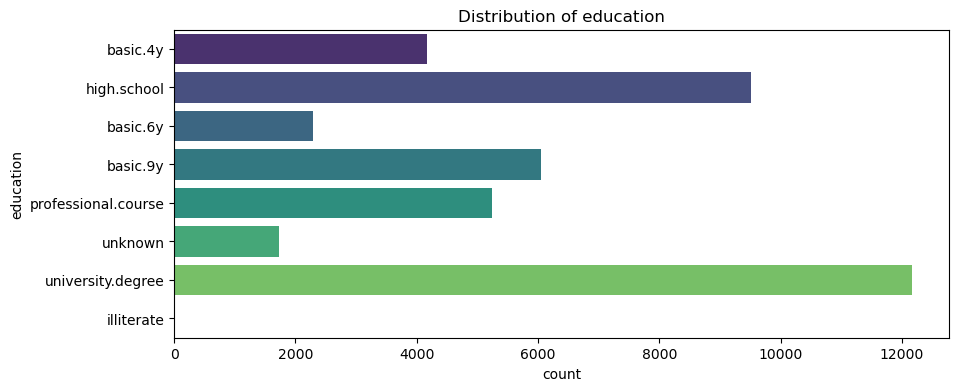

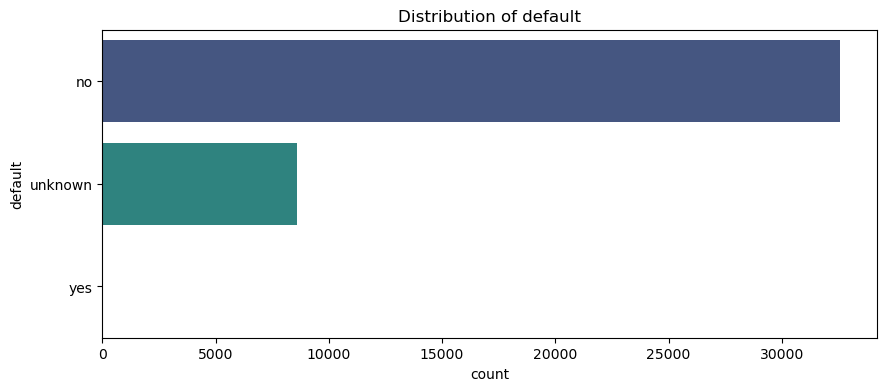

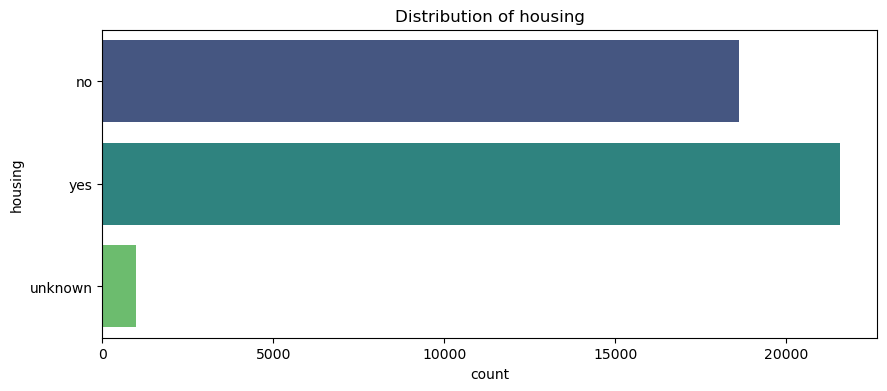

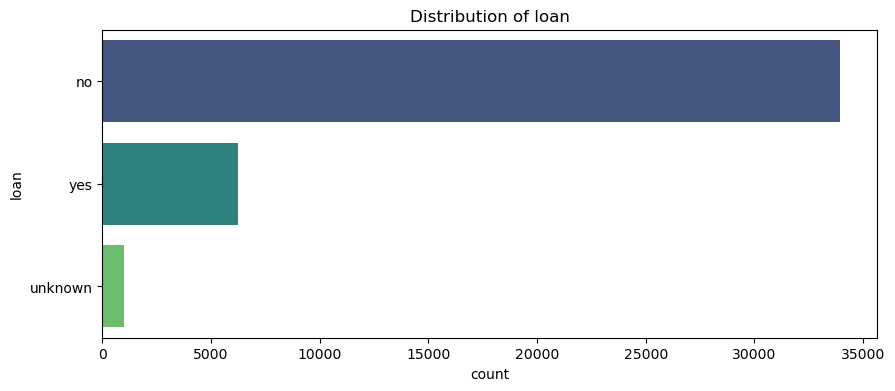

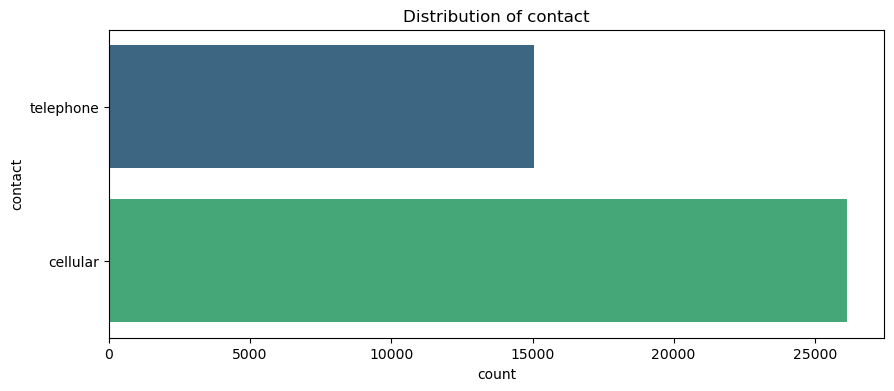

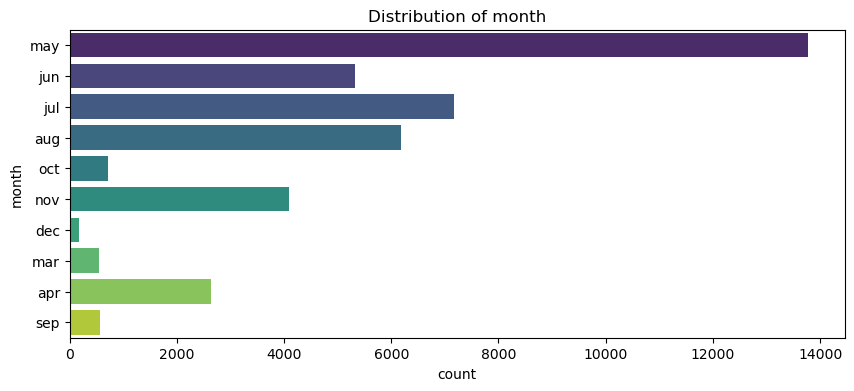

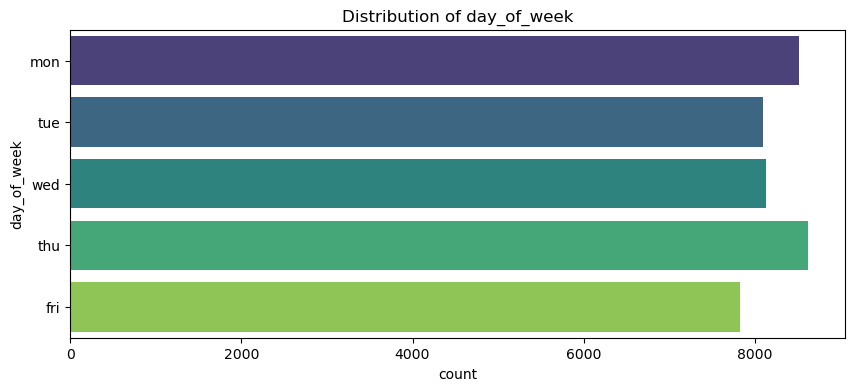

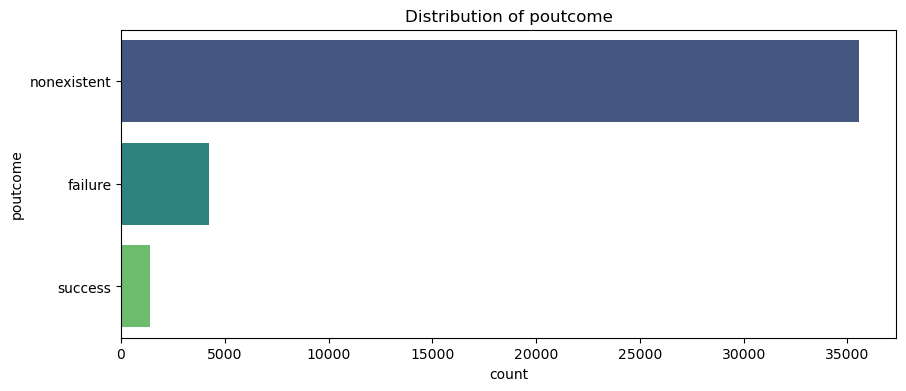

In [6]:
# Step 2: Exploratory Data Analysis (EDA)
def explore_data(df):
    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nClass Distribution:")
    print(df['y'].value_counts())

    # Categorical Feature Distribution
    categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for col in categorical_features:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=df[col], palette='viridis')
        plt.title(f"Distribution of {col}")
        plt.show()

# Call the function (Make sure it's at the same indentation level)
explore_data(data)


In [7]:
# Step 3: Data Preprocessing
def preprocess_data(df):
    df['y_encoded'] = df['y'].map({'yes': 1, 'no': 0})
    categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
    categorical_cols.remove('y')
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    return df

data = preprocess_data(data)

In [8]:
# Step 4: Feature Selection
def select_features(df):
    X = df.drop(columns=['y', 'y_encoded'])
    y = df['y_encoded']
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=10)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    return df[selected_features], y

data_x, data_y = select_features(data)

In [9]:
# Step 5: Handling Imbalanced Data
def balance_data(X, y):
    smt = SMOTE()
    X_resampled, y_resampled = smt.fit_resample(X, y)
    return X_resampled, y_resampled

data_train_x, data_test_x, data_train_y, data_test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
data_train_x_sm, data_train_y_sm = balance_data(data_train_x, data_train_y)

In [10]:
# Step 6: Standardization
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

data_train_x_sm, data_test_x = standardize_data(data_train_x_sm, data_test_x)

In [11]:
# Step 7: Model Training and Evaluation
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return model_name, accuracy

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = []
for name, model in models.items():
    results.append(train_and_evaluate(model, name, data_train_x_sm, data_train_y_sm, data_test_x, data_test_y))


Logistic Regression Accuracy: 0.84
[[6111 1192]
 [ 136  799]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7303
           1       0.40      0.85      0.55       935

    accuracy                           0.84      8238
   macro avg       0.69      0.85      0.72      8238
weighted avg       0.91      0.84      0.86      8238

Naive Bayes Accuracy: 0.76
[[5438 1865]
 [ 149  786]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      7303
           1       0.30      0.84      0.44       935

    accuracy                           0.76      8238
   macro avg       0.63      0.79      0.64      8238
weighted avg       0.90      0.76      0.80      8238

KNN Accuracy: 0.85
[[6209 1094]
 [ 176  759]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7303
           1       0.41      0.81      0.54       935

    accuracy        

In [12]:
# Step 8: Summarize Results
results_df = pd.DataFrame(results, columns=["Model Name", "Accuracy Score"])
print(results_df)


            Model Name  Accuracy Score
0  Logistic Regression        0.838796
1          Naive Bayes        0.755523
2                  KNN        0.845836
